# GAN + MNIST

In this Lab you'll lern how to build GAN networks and apply them to image generation on the MNIST example

## Refs
 - https://d2l.ai/chapter_generative-adversarial-networks/gan.html
 - https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html



# Task: Pokemons

Lets use some funny example (we're using https://d2l.ai/chapter_generative-adversarial-networks/dcgan.html implementation here.

Pokemon dataset:
https://pokemondb.net/sprites
http://d2l-data.s3-accelerate.amazonaws.com/pokemon.zip
https://gist.github.com/armgilles/194bcff35001e7eb53a2a8b441e8b2c6

In [35]:
import mxnet as mx
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn

import numpy

from matplotlib import pyplot as plt
from tqdm import tqdm

npx.set_np()

In [5]:
pokemon_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset('./data/pokemon')

/var/folders/n0/gr734nl92mn93vzmdrl2_wqm0000gn/T/ipykernel_48308/3174118944.py:1: UserWarning: Ignoring ./data/pokemon/.DS_Store, which is not a directory.
  pokemon_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset('./data/pokemon')


In [6]:
# resize each image into 64x64
batch_size = 256

transformer = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(64),
    gluon.data.vision.transforms.ToTensor(),
    gluon.data.vision.transforms.Normalize(0.5, 0.5)
])

data_loader = gluon.data.DataLoader(
    pokemon_dataset.transform_first(transformer),
    batch_size=batch_size,
    shuffle=True )

In [15]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [50]:
def show_one_image(img, title=None):
    """ Plots an image. """

    plt.imshow(img.asnumpy())


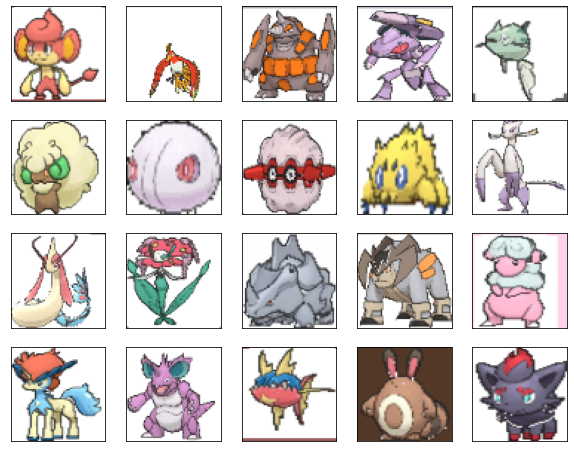

In [17]:
for X, y in data_loader:
    imgs = X[0:20,:,:,:].transpose(0, 2, 3, 1)/2+0.5
    show_images(imgs, num_rows=4, num_cols=5, scale=2)
    break

In [18]:
class G_block(nn.Block):
    def __init__(self, channels, kernel_size=4,
                 strides=2, padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.Conv2DTranspose(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.Activation('relu')

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [19]:
# test shapes -> should double the size
x = np.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk.initialize()
g_blk(x).shape

(2, 20, 32, 32)

In [20]:
# or increase shapes by 3:
x = np.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk.initialize()
g_blk(x).shape

(2, 20, 4, 4)

In [21]:
n_G = 64
net_G = nn.Sequential()
net_G.add(G_block(n_G*8, strides=1, padding=0),  # Output: (64 * 8, 4, 4)
          G_block(n_G*4),  # Output: (64 * 4, 8, 8)
          G_block(n_G*2),  # Output: (64 * 2, 16, 16)
          G_block(n_G),    # Output: (64, 32, 32)
          nn.Conv2DTranspose(
              3, kernel_size=4, strides=2, padding=1, use_bias=False,
              activation='tanh'))  # Output: (3, 64, 64)

In [22]:
# test
x = np.zeros((1, 100, 1, 1))
net_G.initialize()
net_G(x).shape

(1, 3, 64, 64)

In [23]:
class D_block(nn.Block):
    def __init__(self, channels, kernel_size=4, strides=2,
                 padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2D(
            channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = nn.BatchNorm()
        self.activation = nn.LeakyReLU(alpha)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [25]:
# test
x = np.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk.initialize()
d_blk(x).shape

(2, 20, 8, 8)

In [26]:
n_D = 64
net_D = nn.Sequential()
net_D.add(D_block(n_D),   # Output: (64, 32, 32)
          D_block(n_D*2),  # Output: (64 * 2, 16, 16)
          D_block(n_D*4),  # Output: (64 * 4, 8, 8)
          D_block(n_D*8),  # Output: (64 * 8, 4, 4)
          nn.Conv2D(1, kernel_size=4, use_bias=False))  # Output: (1, 1, 1)

In [27]:
# test
x = np.zeros((1, 3, 64, 64))
net_D.initialize()
net_D(x).shape

(1, 1, 1, 1)

In [29]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = np.ones((batch_size,), ctx=Z.ctx)
    with autograd.record():
        # We could reuse `fake_X` from `update_D` to save computation
        fake_X = net_G(Z)
        # Recomputing `fake_Y` is needed since `net_D` is changed
        fake_Y = net_D(fake_X)
        loss_G = loss(fake_Y, ones)
    loss_G.backward()
    trainer_G.step(batch_size)
    return float(loss_G.sum())

In [30]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = np.ones((batch_size,), ctx=X.ctx)
    zeros = np.zeros((batch_size,), ctx=X.ctx)
    with autograd.record():
        real_Y = net_D(X)
        fake_X = net_G(Z)
        # Do not need to compute gradient for `net_G`, detach it from
        # computing gradients.
        fake_Y = net_D(fake_X.detach())
        loss_D = (loss(real_Y, ones) + loss(fake_Y, zeros)) / 2
    loss_D.backward()
    trainer_D.step(batch_size)
    return float(loss_D.sum())

In [28]:
ctx = mx.gpu(0) if mx.context.num_gpus() > 0 else mx.cpu(0)

In [39]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=ctx):
    loss = gluon.loss.SigmoidBCELoss()

    net_D.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)
    net_G.initialize(init=init.Normal(0.02), force_reinit=True, ctx=device)

    trainer_hp = {'learning_rate': lr, 'beta1': 0.5}

    trainer_D = gluon.Trainer(net_D.collect_params(), 'adam', trainer_hp)
    trainer_G = gluon.Trainer(net_G.collect_params(), 'adam', trainer_hp)

    history_D = []
    history_G = []

    for epoch in range(1, num_epochs + 1):
        # Train one epoch and track loss per batches
        epoch_history_D = []
        epoch_history_G = []

        total_batches = len(data_iter)

        with tqdm(total=total_batches, position=0, leave=True) as pbar:
            for batch_num, (X, _) in enumerate(data_iter):
                batch_size = X.shape[0]
                Z = np.random.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
                X, Z = X.as_in_ctx(device), Z.as_in_ctx(device)

                loss_D = update_D(X, Z, net_D, net_G, loss, trainer_D)
                loss_D = loss_D/batch_size

                loss_G = update_G(Z, net_D, net_G, loss, trainer_G)
                loss_G = loss_G/batch_size

                epoch_history_D.append(loss_D)
                epoch_history_G.append(loss_G)

                pbar.set_description(f'Epoch: {epoch}, Batch: {batch_num}/{total_batches},'
                                     f'Loss(D): {loss_D:.3f}, Loss (G): {loss_G:.3f}')
                pbar.update()

            # Show generated examples
            # Z = np.random.normal(0, 1, size=(21, latent_dim, 1, 1), ctx=device)
            # Normalize the synthetic data to N(0, 1)
            # fake_x = net_G(Z).transpose(0, 2, 3, 1) / 2 + 0.5
            # imgs = np.concatenate(
            #     [np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
            #      for i in range(len(fake_x)//7)], axis=0)

            # Show the losses
            loss_D = np.mean(epoch_history_D)
            loss_G = epoch_history_G.mean()

            history_D.append(loss_D)
            history_G.append(loss_G)

        pbar.close()

In [ ]:
#latent_dim, lr, num_epochs = 100, 0.005, 20
latent_dim, lr, num_epochs = 100, 0.04, 3
train(net_D, net_G, data_loader, num_epochs, lr, latent_dim)

Epoch: 1, Batch: 22/159,Loss(D): 1.972, Loss (G): 14.008:  14%|█▍        | 23/159 [12:44<1:42:32, 45.24s/it] 

In [43]:
net_G

Sequential(
  (0): G_block(
    (conv2d_trans): Conv2DTranspose(512 -> 100, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (batch_norm): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512)
    (activation): Activation(relu)
  )
  (1): G_block(
    (conv2d_trans): Conv2DTranspose(256 -> 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=256)
    (activation): Activation(relu)
  )
  (2): G_block(
    (conv2d_trans): Conv2DTranspose(128 -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
    (activation): Activation(relu)
  )
  (3): G_block(
    (conv2d_trans): Conv2DTranspose(64 -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): Batch

In [80]:
# Show generated examples
Z = np.random.normal(0, 1, size=(5, latent_dim, 1, 1), ctx=ctx)
Z = Z.as_in_ctx(ctx)
Z.shape

(5, 100, 1, 1)

In [81]:
fake_x = net_G(Z)
fake_x.shape

(5, 3, 64, 64)

In [89]:
# Normalize the synthetic data to N(0, 1)

im = (fake_x.transpose(0, 2, 3, 1) / 2 + 0.5)*255
im.shape

(5, 64, 64, 3)

In [78]:
imgs = np.concatenate(
    [np.concatenate([fake_x[i * 7 + j] for j in range(7)], axis=1)
     for i in range(len(fake_x)//7)], axis=0)
show_images(imgs, 1, 1)

MXNetError: MXNetError: value 0 for Parameter num_args should be greater equal to 1
num_args: Number of inputs to be concated., in operator _npi_concatenate(name="", num_args="0", axis="0")

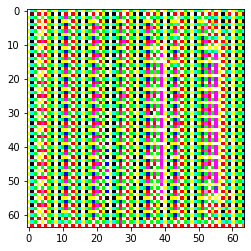

In [90]:
show_one_image(im[1])